# Numero de revisiones 

In [375]:
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

Import Lista planillas 

In [376]:
lista_planillas=pd.read_csv('DATASET/Lista_planillas_COMPLETE.csv',
                            index_col=0,
                            #parse_dates=['Fecha'],
                            #infer_datetime_format=True)
                           )


Import Lista detalles

In [377]:
# Importar planillas de detalles
planilla_detalles=pd.read_csv('DATASET/0.0.planillas.detalle.COMPLETE.csv',
                              index_col='Planilla',
                              dtype={'Modelo':'Int64','Planilla':'Int64'})


Import lista historico de revisiones 

In [378]:
historico_revisiones=pd.read_csv('DATASET/0.0.planillas.hist.COMPLETE.csv',
                                 index_col='Planilla',
                                 #parse_dates=['Fecha'],
                                 #infer_datetime_format=True)
                                )


# Data Cleaning 

Lista de detalles

In [379]:
#Eliminar filas vacias
planilla_detalles.dropna(inplace=True)

#Cambiar nombre columnas
planilla_detalles.rename(columns={'Dominio:':'Dominio','Convenio:':'Convenio'},inplace=True)

#Eliminar columna innecesaria
planilla_detalles.drop(columns='Unnamed: 0',inplace=True)

lista historio de revisones

In [380]:
#Eliminar columna innecesaria
historico_revisiones.drop(columns='Unnamed: 0',inplace=True)

Lista de planillas

<AxesSubplot:>

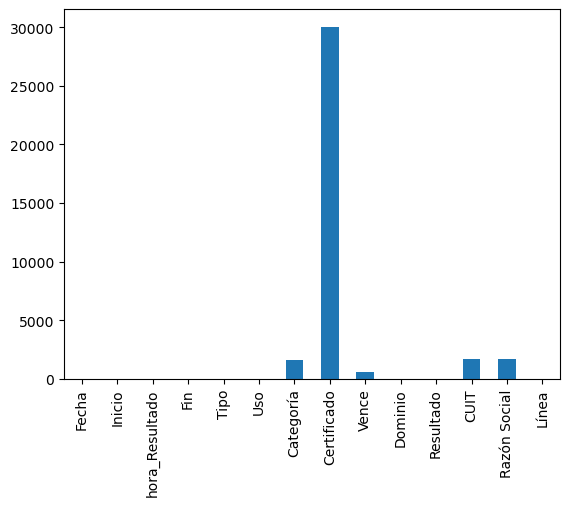

In [381]:
lista_planillas.isna().sum().plot(kind='bar')

In [389]:
#Cambiar Fecha a formato datetime
lista_planillas['Fecha'] = pd.to_datetime(lista_planillas['Fecha'], format="%d/%m/%Y")

historico_revisiones['Fecha'] = pd.to_datetime(historico_revisiones['Fecha'], format="%d/%m/%Y")




#Crear Columnas : Anio,Mes,Mes_label, Anio y mes 
lista_planillas['Anio']=lista_planillas['Fecha'].dt.year

lista_planillas['Mes']=lista_planillas['Fecha'].dt.month

lista_planillas['Mes_label']=lista_planillas['Fecha'].dt.month_name(locale='es_ES')

lista_planillas['Anio y Mes']=lista_planillas['Anio'].astype(str)+lista_planillas['Mes'].astype(str)

# Mostrar CUIT en formato correcto 
lista_planillas['CUIT']=lista_planillas['CUIT'].astype('Int64')
#pd.options.display.float_format = '{:.0f}'.format

# Borrar espacios de Razon Social  
lista_planillas['Razón Social']=lista_planillas['Razón Social'].str.replace('\W', ' ', regex=True)

# Borrar asteriscos de Dominio
lista_planillas['Dominio']=lista_planillas['Dominio'].str.replace('\W', ' ', regex=True)




Establecer una unica Razon Social para cada CUIT: 

Por errores de data entry, hay varios valores de razon social para un mismo CUIT. 

In [390]:
#Eliminar Cuit repetidos:
df_cuit_razon_social=lista_planillas[['CUIT','Razón Social']].drop_duplicates(subset=['CUIT']).sort_values('CUIT') 

#Usar CUIT como index
df_cuit_razon_social.set_index('CUIT',inplace=True)


#Transponer dataframe y pasarlo a lista de valores en el formato [{CUIT:Razon Social,CUIT:Razon Social}]
list_dict_cuit_razon_social=df_cuit_razon_social.T.to_dict(orient='records')


#El dicionario esta dentro de la lista, seleccionamos el indice [0] de la lista para obtenerlo
dict_cuit_razon_social=list_dict_cuit_razon_social[0]


In [391]:
#Creamos columna Razon Social Unica. Mapeamos los valores desde el diccionario 
lista_planillas['Razón Social Unica']=lista_planillas['CUIT'].map(dict_cuit_razon_social)

# Agregar Modelo a lista de planillas

In [392]:
#planilla de key : Dominio : Modelo 
planilla_detalles_key=planilla_detalles[['Modelo','Dominio']].drop_duplicates(subset=['Dominio'])

# Agregar con left merge 
lista_planillas_completa=lista_planillas.merge(planilla_detalles_key,how='left',left_on='Dominio',right_on='Dominio')


In [393]:
#Agregar antiguedad al momento de la revision 
lista_planillas_completa['antiguedad_revision']=lista_planillas_completa['Anio']-lista_planillas_completa['Modelo']

# Agregar columna Planilla&Dominio
Para tener como unique key y/o index depende de las necesidades

Agrego esta columna en todas las planillas

In [394]:
lista_planillas['Planilla&Dominio']=lista_planillas.index.astype(str)+lista_planillas['Dominio']

planilla_detalles['Planilla&Dominio']=planilla_detalles.index.astype(str)+planilla_detalles['Dominio']

historico_revisiones['Planilla&Dominio']=historico_revisiones.index.astype(str)+historico_revisiones['Dominio']


# Eliminar duplicados 

In [395]:
lista_planillas.drop_duplicates(subset=('Planilla&Dominio'),inplace=True)

planilla_detalles.drop_duplicates(subset=('Planilla&Dominio'),inplace=True)

historico_revisiones.drop_duplicates(subset=('Planilla&Dominio'),inplace=True)

# Flota total de cada Empresa

In [396]:
#Eliminamos los duplicados de los pares Patente-CUIT . una misma patente pudo ser transferida por lo que si borramos todos los duplicados de patentes perderiamos esa informacion 
lista_planillas_dominio=lista_planillas.drop_duplicates(subset=['Dominio','CUIT'])

#Creamos una planilla agrupando y contando los dominios por Razon Social Unica.
vehiculos_por_cliente=lista_planillas_dominio.groupby('Razón Social Unica')[['Dominio']].count()

#Cambiamos el nombre de la columna por uno mas adecuado Revisiones Totales
vehiculos_por_cliente.rename(columns={'Dominio':'Flota Historica'},inplace=True)

#Ordenamos los Clientes  por mayor numero de Revisiones totales 
vehiculos_por_cliente.sort_values('Flota Historica',ascending=False).head(10)

,Flota Historica
Razón Social Unica,
AMARILLA GAS S A,383
ERSA URBANO SA,287
ADOLFO SARTORI SA,286
TELECOM ARGENTINA S A,261
NUEVO BANCO DEL CHACO S A,209
CARSA SACI,113
EMPRESA TIRO FEDERAL RCIA SRL,110
DERUDDER HERMANOS S R L,104
ERSA CHACO S A,100


# Mejores clientes Historico

In [397]:
#Creamos una planilla agrupando y contando los dominios por Razon Social Unica.
vehiculos_por_cliente=lista_planillas.groupby('Razón Social Unica')[['Dominio']].count()

#Cambiamos el nombre de la columna por uno mas adecuado Revisiones Totales
vehiculos_por_cliente.rename(columns={'Dominio':'Revisiones Totales'},inplace=True)

#Ordenamos los Clientes  por mayor numero de Revisiones totales 
vehiculos_por_cliente.sort_values('Revisiones Totales',ascending=False).head(10)

,Revisiones Totales
Razón Social Unica,
ERSA URBANO SA,1107
ADOLFO SARTORI SA,1062
AMARILLA GAS S A,1026
EMPRESA TIRO FEDERAL RCIA SRL,984
ERSA CHACO S A,689
TELECOM ARGENTINA S A,664
SAN FERNANDO URBANO S R L,630
EMPRESA LA TERMAL S R L,464
EMPRESA LA ESTRELLA S R L,458


# Mejores clientes por año 

In [398]:
vehiculos_por_cliente_anual=pd.pivot_table(lista_planillas,index='Razón Social Unica',values='CUIT',columns='Anio',aggfunc='count')

In [399]:
#reemplazo na por 0
vehiculos_por_cliente_anual.fillna(0,inplace=True)

In [400]:
vehiculos_por_cliente_anual.sort_values(2022,ascending=False).head(10)

Anio,2014,2015,2016,2017,2018,2019,2020,2021,2022
Razón Social Unica,,,,,,,,,
ERSA URBANO SA,17.0,29.0,44.0,65.0,135.0,239.0,140.0,223.0,215.0
AMARILLA GAS S A,14.0,87.0,92.0,109.0,110.0,122.0,163.0,176.0,153.0
ADOLFO SARTORI SA,24.0,125.0,125.0,142.0,117.0,134.0,127.0,133.0,135.0
EMPRESA TIRO FEDERAL RCIA SRL,35.0,116.0,131.0,147.0,131.0,126.0,88.0,114.0,96.0
TELECOM ARGENTINA S A,22.0,60.0,92.0,89.0,70.0,76.0,70.0,90.0,95.0
INDUSTRIAL Y CONSTRUCTORA S A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,75.0
SAN FERNANDO URBANO S R L,18.0,127.0,135.0,81.0,64.0,53.0,43.0,48.0,61.0
LA CORDIAL SRL,6.0,62.0,55.0,50.0,67.0,51.0,52.0,50.0,56.0
CASA GAONA S A,3.0,34.0,37.0,46.0,26.0,32.0,44.0,35.0,54.0


Ranking Mejores clientes por año 

In [110]:
#Lista de Empresas que fueron top en algun año 
lt=[]
for a in range (2014,2023):
    l=vehiculos_por_cliente_anual.nlargest(5,a).index.tolist()
    lt=lt+l
lt=set(lt)
#lt=[elem[:20]for elem  in lt]
lt=list(lt)


<AxesSubplot:xlabel='Anio'>

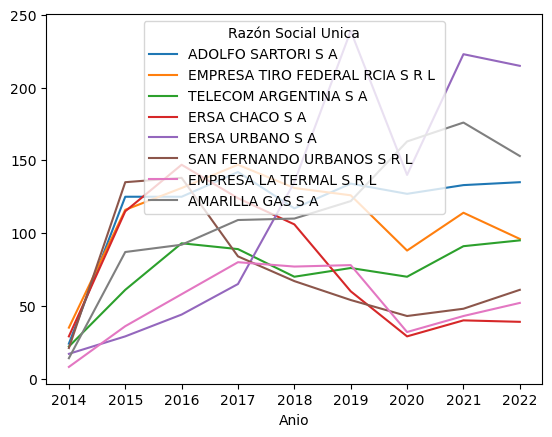

In [111]:
# Transpongo la tabla para tener la fecha de index
#Filtro la tabla con la lista de empresas que fueron top 5 en algun año
vehiculos_por_cliente_anual_t=vehiculos_por_cliente_anual.loc[lt].T
vehiculos_por_cliente_anual_t.plot(kind='line')

Ranking Mejores clientes Acumulado

In [112]:
#Tabla pivot usando pd.grouper para agrupar mensualmente en la columna FECHA
vehiculos_por_cliente_mensual=pd.pivot_table(lista_planillas,index='Razón Social Unica',values='CUIT',columns=pd.Grouper(key='Fecha',freq='M'),aggfunc='count')

In [113]:
#reemplazo na por 0
vehiculos_por_cliente_mensual.fillna(0,inplace=True)

In [114]:
#Lista de Empresas que fueron top en algun año
lt=[]
for a in range (2014,2023):
    l=vehiculos_por_cliente_anual.nlargest(12,a).index.tolist()
    lt=lt+l
lt=set(lt)
#lt=[elem[:20]for elem  in lt]
lt=list(lt)


In [115]:
# Transpongo la tabla para tener la fecha de index 
#Filtro la tabla con la lista de empresas que fueron top 12 en algun año
vehiculos_por_cliente_mensual_t=vehiculos_por_cliente_mensual.loc[lt].T

In [116]:
# Uso CUMSUM para obtener el total de revisiones hasta la fecha de cada empresa

vehiculos_por_cliente_mensual_sum=vehiculos_por_cliente_mensual_t.cumsum(axis=0)

In [117]:
#Ordeno por fecha
vehiculos_por_cliente_mensual_sum.sort_index(inplace=True)

In [118]:
#Filtrar año >=2015
vehiculos_por_cliente_mensual_sum.loc['2015-01-01':]

Razón Social Unica,EMPRESA TIRO FEDERAL RCIA S R L,FABRICA S R L,ERSA URBANO S A,CONSTRUCCIONES BOR SRL,EMPRESA LA TERMAL S R L,DERUDDER HOS S R L FLECHA BUS,CETROGAR S A,TECSA S R L,CARSA S A,DIRECCIÓN NACIONAL DE VIALIDAD,...,LA CORDIAL S R L,MELLI HNOS S A,DOLZANI HNOS DOLZANI R MARIO Y DOLZANI O RUBEN S H,INDUSTRIAL Y CONSTRUCTORA S A,SNAIDER OMAR ALBERTO,HIJOS DE ROBERTO CANCIO DEMONTE S A,TRANSPORTES ERSA CARGAS S A,NUEVO BANCO DEL CHACO S A,TELECOM ARGENTINA S A,ERSA CHACO S A
Fecha,,,,,,,,,,,,,,,,,,,,,
2015-01-31,49.0,6.0,20.0,11.0,10.0,5.0,7.0,2.0,19.0,18.0,...,12.0,7.0,12.0,0.0,16.0,11.0,0.0,6.0,28.0,34.0
2015-02-28,55.0,9.0,23.0,13.0,13.0,10.0,8.0,2.0,20.0,19.0,...,22.0,7.0,13.0,0.0,23.0,12.0,0.0,9.0,34.0,48.0
2015-03-31,61.0,12.0,26.0,16.0,18.0,13.0,8.0,2.0,24.0,19.0,...,26.0,7.0,16.0,0.0,26.0,14.0,0.0,10.0,40.0,54.0
2015-04-30,75.0,15.0,26.0,24.0,23.0,15.0,9.0,2.0,27.0,22.0,...,33.0,10.0,22.0,0.0,26.0,16.0,0.0,12.0,58.0,64.0
2015-05-31,92.0,18.0,27.0,29.0,25.0,20.0,12.0,6.0,33.0,22.0,...,34.0,10.0,27.0,0.0,30.0,18.0,0.0,13.0,60.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,951.0,165.0,1039.0,59.0,446.0,176.0,243.0,181.0,345.0,39.0,...,425.0,244.0,205.0,78.0,295.0,162.0,63.0,230.0,646.0,678.0
2022-09-30,966.0,165.0,1056.0,59.0,451.0,176.0,248.0,182.0,346.0,39.0,...,429.0,245.0,205.0,88.0,298.0,162.0,65.0,230.0,648.0,682.0
2022-10-31,971.0,165.0,1080.0,59.0,455.0,176.0,251.0,186.0,346.0,39.0,...,437.0,248.0,206.0,95.0,298.0,162.0,66.0,230.0,654.0,686.0


import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge bar_chart_race

In [119]:
# Importar bar chart race 
import bar_chart_race as bcr

ModuleNotFoundError: No module named 'bar_chart_race'

In [ ]:
# bar chart race comenzando desde 2015
bcr.bar_chart_race(
    df=vehiculos_por_cliente_mensual_sum.loc['2015-01-01':],
    n_bars=10,
    filename=None,
    perpendicular_bar_func='median',
    title='Cantidad Total de Revisiones',
    filter_column_colors=True)

# Curiosidades

Vehiculos mas viejos del taller

In [401]:
# Crear planilla con Dominio , modelo ,y antiguedad al momento de la revision 
dominio_antiguedad=lista_planillas_completa[['Dominio','Modelo','antiguedad_revision','Categoría','Fecha','Línea']]

In [402]:
dominio_antiguedad=dominio_antiguedad.dropna()
lista_antiguedad=dominio_antiguedad.drop_duplicates(subset=['Dominio'])

Vehiculos mas viejos Historico

In [403]:
# Filtrar para Vehiculos particulares 
filtro_uso=lista_antiguedad['Categoría']=='UP'

lista_antiguedad_up=lista_antiguedad[filtro_uso]
lista_antiguedad_up.sort_values('Modelo',ascending=True).head(10)

,Dominio,Modelo,antiguedad_revision,Categoría,Fecha,Línea
1185,UDQ363,1937,77,UP,2014-11-07,2
7239,SPF091,1958,57,UP,2015-02-18,2
75458,SIE561,1958,60,UP,2018-05-07,1
14991,RGQ626,1961,54,UP,2015-07-16,2
51189,WIC007,1961,56,UP,2017-03-16,1
32290,SYV328,1963,53,UP,2016-05-13,1
24907,TIK356,1965,51,UP,2016-01-08,2
44214,VZN377,1966,50,UP,2016-12-05,2
127095,VBI582,1966,54,UP,2020-12-18,2
22071,WAF718,1966,49,UP,2015-11-20,1


Vehiculos mas viejos desde 2021 

In [404]:
# Filtrar para Vehiculos particulares
filtro_uso=lista_antiguedad['Categoría']=='UP'
# Filtrar para año de revision 
filtro_fecha=lista_antiguedad['Fecha']>='2021-10-01'

lista_antiguedad_up=lista_antiguedad[filtro_uso&filtro_fecha]

lista_antiguedad_up.sort_values('Modelo',ascending=True).head(10)

,Dominio,Modelo,antiguedad_revision,Categoría,Fecha,Línea
171619,RVR795,1969,53,UP,2022-10-17,2
168500,UTO403,1970,52,UP,2022-08-27,1
165706,VHY172,1972,50,UP,2022-07-14,1
152291,VLO777,1972,49,UP,2021-12-16,1
158571,PPZ395,1973,49,UP,2022-03-11,1
148926,UKM565,1973,48,UP,2021-10-29,1
158398,SWH991,1975,47,UP,2022-03-09,1
156395,RIJ600,1975,47,UP,2022-02-09,1
156101,UIL993,1977,45,UP,2022-02-05,1
154806,WBB227,1978,44,UP,2022-01-20,2


Vehiculos mas viejos desde 2021 REVISADOS EN LINEA 2

In [405]:
# Filtrar para Vehiculos particulares
filtro_uso=lista_antiguedad['Categoría']=='UP'
# Filtrar para año de revision 
filtro_fecha=lista_antiguedad['Fecha'].between('2021-10-01','2022-08-01')
#filtrar para linea 2 
filtro_linea=lista_antiguedad['Línea']==2


lista_antiguedad_up=lista_antiguedad[filtro_uso&filtro_fecha&filtro_linea]

lista_antiguedad_up.sort_values('Modelo',ascending=True).head(10)

,Dominio,Modelo,antiguedad_revision,Categoría,Fecha,Línea
154806,WBB227,1978,44,UP,2022-01-20,2
164798,VSJ329,1979,43,UP,2022-06-30,2
165837,RTI973,1981,41,UP,2022-07-15,2
151386,UFL674,1981,40,UP,2021-12-04,2
153505,RXH295,1988,34,UP,2022-01-03,2
148406,RND572,1989,32,UP,2021-10-22,2
153397,VRE783,1990,31,UP,2021-12-31,2
153407,WIT268,1990,31,UP,2021-12-31,2
154962,VBG922,1990,32,UP,2022-01-21,2
148340,VFK220,1992,29,UP,2021-10-22,2


# Perdida de Clientes 

In [406]:
#Lista de Dominios de revisiones dentro del taller :
lista_dominios_unicos=lista_planillas['Dominio'].drop_duplicates()

# Filtro la planilla historico_revisiones para tener solo los Dominios que alguna vez hayan realizado la revision en el taller
filtro_dominio=historico_revisiones['Dominio'].isin(lista_dominios_unicos)

historico_revisiones_taller=historico_revisiones[filtro_dominio].copy()


In [407]:
historico_revisiones_taller

,Dominio,Taller,Tipo Uso,Fecha,Resultado,Versión RTO,Planilla&Dominio
Planilla,,,,,,,
1173505,AA000HG,4,PX,2022-11-14,Apto,2014,1173505AA000HG
1124182,AA000HG,4,PX,2020-11-05,Apto,2014,1124182AA000HG
1053004,AA000HG,65,PX,2018-09-04,Apto,2014,1053004AA000HG
1154432,AA001GK,4,PX,2022-01-13,Apto,2014,1154432AA001GK
1066213,AA001GK,65,PX,2020-01-07,Apto,2014,1066213AA001GK
...,...,...,...,...,...,...,...
1037818,XOO415,4,PX,2016-08-19,Apto,2014,1037818XOO415
1074450,XOO981,4,PX,2018-04-17,Apto,2014,1074450XOO981
1039212,XOS697,4,PX,2016-09-13,Apto,2014,1039212XOS697


In [ ]:
#Calculo fecha min Proxima revision 

historico_revisiones_taller['Fecha_prox']=historico_revisiones_taller['Fecha']+datetime.timedelta(days=70)

#Calculo fecha min revision anterior 

historico_revisiones_taller['Fecha_ant']=historico_revisiones_taller['Fecha']-datetime.timedelta(days=70)

#crear columna Retencion_cliente dentro de la planilla perdida de clientes 
historico_revisiones_taller['Retencion_cliente']='Nada'



Cambiar Index de la planilla :

In [ ]:

# Primero Reinicio index para no perder el index anterior ( Planilla ) 
historico_revisiones_taller.reset_index(inplace=True) 

#Uso la columna Planilla&Dominio como index, ya que este no se repite
historico_revisiones_taller.set_index('Planilla&Dominio',inplace=True)

In [ ]:
historico_revisiones_taller

# USAR COPY PARA HACER LA TABLA DE RANKING DE CLIENTES QUE NO ME SALIA< 

AA000HG es buen dominio para probar 

Cuando NO es retencion de cliente :
    -Numero de taller siguiente es distinto
      
Cuando SI es retencion de cliente:
    -Numero de taller siguiente es el Mismo

Cuando Ignorar/no es ninguno:

    -La tecninca luego de un Condicional (si esta dentro de los 60 dias )
    
    -Si no hay tecnica siguiente 
    
    -la Tecnica luego de un Rechazado (dentro de los 60 dias)



Eliminar Tecnicas que se realizaron sin cargo

In [44]:
# Crear tablas de Revisiones Condicionales en Nuestro taller

#Filtro revisiones condicionales     
filtro_condicional=historico_revisiones_taller['Resultado']=='Condicional'

#Filtro revisiones rechazadas 
filtro_rechazado=historico_revisiones_taller['Resultado']=='Rechazado'

#Filtro las revisiones condicionales que se hicieron en nuestro taller : Solo las revisiones en nuestro taller tendran la prox gratis 
filtro_taller=historico_revisiones_taller['Taller']==4


# Creo tabla temporal
temp=historico_revisiones_taller.loc[((filtro_condicional|filtro_rechazado)&filtro_taller),['Planilla','Resultado','Dominio','Fecha','Fecha_prox']]


# Creo tabla temporal de revisiones en nuestro Taller:Solo seran gratis tecnicas en nuestro taller 

temp_taller_4=historico_revisiones_taller[historico_revisiones_taller['Taller']==4]



In [45]:
# import tqdm to see progress bar 
from tqdm.notebook import tqdm

Numero de planillas se repiten. 

Numero de planillas&Dominio no se repiten

creo una columna nueva con numero de planilla&dominio y lo uso como index nuevo en ambos dataframes 


In [46]:
#Lista de Revisiones que SERIAN gratis en nuestro taller 
lista_rev_gratis=[]
for i in tqdm((temp.index)):
    #Planilla
    planilla=temp.loc[i,'Planilla']
    
    #Dominio
    dominio=temp.loc[i,'Dominio']
    #print(dominio)
   
    #Fecha 
    fecha=temp.loc[i,'Fecha']
    
    #Fecha prox
    fecha_prox=temp.loc[i,'Fecha_prox']
    
    #Filtro Dominio
    filtro_dominio=temp_taller_4['Dominio']==dominio
   
    
    #Filtro Fecha
    filtro_fecha=temp_taller_4['Fecha'].between(fecha,fecha_prox,inclusive='both')
    
    #Filtro planilla
    filtro_planilla=temp_taller_4['Planilla']!=planilla
    
    #REVISIONES QUE SERIAN GRATIS EN NUESTRO TALLER 
    revisiones_gratis=temp_taller_4[filtro_dominio&filtro_fecha&filtro_planilla]
    
    if not revisiones_gratis.empty:
        lista_rev_gratis.append(revisiones_gratis.index.tolist())
        
#print (lista_rev_gratis)

  0%|          | 0/17604 [00:00<?, ?it/s]

In [48]:
# Convertir una lista de listas , a una lista

#con for loop 
lista_rev_gratis_flat = []
for sublist in lista_rev_gratis:
    for item in sublist:
        lista_rev_gratis_flat.append(item)

        # con list comprehension
#lista_rev_gratis_flat=[item for sublist in lista_rev_gratis for item in sublist]

Lista de revisiones que fueron pagadas 

In [49]:
#Filtro revisiones gratis
filtro_revisiones_gratis=~historico_revisiones_taller.index.isin(lista_rev_gratis_flat)


retencion_clientes=historico_revisiones_taller.loc[filtro_revisiones_gratis].copy()

Cuando NO es retencion de cliente : -Numero de taller siguiente es distinto

Cuando SI es retencion de cliente: -Numero de taller siguiente es el Mismo

In [52]:
# series shift : Tengo que hacer para slices de dataframe
# Pandas shift within a group 

#https://stackoverflow.com/questions/53335567/use-pandas-shift-within-a-group

retencion_clientes['taller_siguiente']=retencion_clientes.groupby('Dominio')['Taller'].shift(1)


Eliminar revisiones si fue la ultima tecnica 

In [53]:
retencion_clientes.dropna(subset='taller_siguiente',inplace=True)

Retencion:

In [54]:
retencion_clientes['Retencion_cliente']='asd'
for i in tqdm((retencion_clientes.index)):
    # Dar valores a retencion_cliente
    taller=retencion_clientes.loc[i,'Taller']
    taller_siguiente=retencion_clientes.loc[i,'taller_siguiente']

    if taller==4:
        if taller_siguiente==4:
            retencion_clientes.loc[i,'Retencion_cliente']='retencion'
        else:
            retencion_clientes.loc[i,'Retencion_cliente']='perdio'


    else:
        if taller_siguiente==4:
            retencion_clientes.loc[i,'Retencion_cliente']='gano'
        else:
            retencion_clientes.loc[i,'Retencion_cliente']='no gano'



  0%|          | 0/170084 [00:00<?, ?it/s]

In [55]:
retencion_clientes.groupby('Retencion_cliente').count()

,Planilla,Dominio,Taller,Tipo Uso,Fecha,Resultado,Versión RTO,Fecha_prox,Fecha_ant,taller_siguiente
Retencion_cliente,,,,,,,,,,
gano,24228,24228,24228,24228,24228,24228,24228,24228,24228,24228
no gano,59545,59545,59545,59545,59545,59545,59545,59545,59545,59545
perdio,27538,27538,27538,27538,27538,27538,27538,27538,27538,27538
retencion,58773,58773,58773,58773,58773,58773,58773,58773,58773,58773


In [56]:
retencion_clientes_pivot=pd.crosstab(index=retencion_clientes['Resultado'],
                                     values=retencion_clientes['Dominio'],
                                    columns=retencion_clientes['Retencion_cliente'],
                                    aggfunc='count')
retencion_clientes_pivot

Retencion_cliente,gano,no gano,perdio,retencion
Resultado,,,,
Apto,23412,44887,23139,52699
Condicional,702,12578,4297,5947
Rechazado,114,2080,102,127


In [57]:
retencion_clientes_pivot_perc=pd.crosstab(index=retencion_clientes['Resultado'],
                                     values=retencion_clientes['Dominio'],
                                    columns=retencion_clientes['Retencion_cliente'],
                                    aggfunc='count',
                                    normalize='index')
retencion_clientes_pivot_perc.round(3)*100

Retencion_cliente,gano,no gano,perdio,retencion
Resultado,,,,
Apto,16.2,31.1,16.1,36.6
Condicional,3.0,53.5,18.3,25.3
Rechazado,4.7,85.8,4.2,5.2


Si solo evaluamos el efecto de las revisiones en nuestro taller:

In [67]:
retencion_clientes_pivot_taller_4=retencion_clientes_pivot.iloc[:,[2,3]].copy()


In [68]:
retencion_clientes_pivot_taller_4

Retencion_cliente,perdio,retencion
Resultado,,
Apto,23139,52699
Condicional,4297,5947
Rechazado,102,127


In [60]:
retencion_clientes_pivot_taller_4_perc=pd.DataFrame()
retencion_clientes_pivot_taller_4_perc[['perdio', 'retencion']] = retencion_clientes_pivot_taller_4[['perdio', 'retencion']].apply(lambda x: x/x.sum(), axis=1)

In [61]:
retencion_clientes_pivot_taller_4_perc.round(3)*100

,perdio,retencion
Resultado,,
Apto,30.5,69.5
Condicional,41.9,58.1
Rechazado,44.5,55.5


In [62]:
retencion_tot=retencion_clientes_pivot_taller_4.sum()
retencion=((retencion_tot['retencion']/retencion_tot.sum())*100).round(1)
retencion

68.1

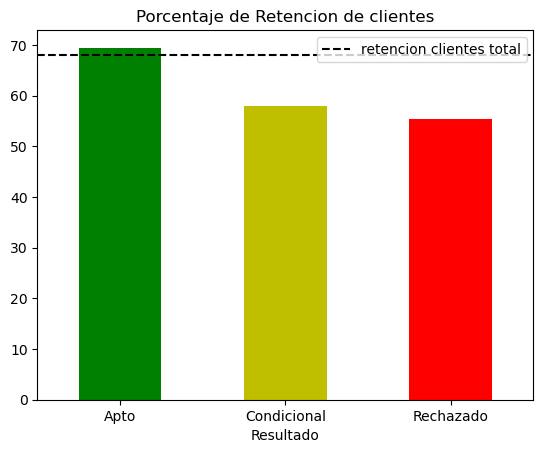

In [63]:


(retencion_clientes_pivot_taller_4_perc['retencion']*100).plot.bar( title='Porcentaje de Retencion de clientes',rot=0,color=(['g','y','r']))

plt.xticks(rotation=0)

plt.axhline(y=retencion, color='k', linestyle='--')


labels = ["retencion clientes total"]
plt.legend(labels=labels)

plt.show()

El resultado de la revision tiene un impacto en la retencion de clientes.

Sin embargo la diferencia no es tan grande como ubiesemos estimados a priori 

Si solo evaluamos el efecto de las revisiones en LOS DEMAS talleres:

In [65]:
retencion_clientes_pivot_taller_not_4=retencion_clientes_pivot.iloc[:,[0,1]].copy()


In [69]:
retencion_clientes_pivot_taller_not_4

Retencion_cliente,gano,no gano
Resultado,,
Apto,23412,44887
Condicional,702,12578
Rechazado,114,2080


In [70]:
retencion_clientes_pivot_taller_not_4_perc=pd.DataFrame()
retencion_clientes_pivot_taller_not_4_perc[['gano', 'no gano']] = retencion_clientes_pivot_taller_not_4[['gano', 'no gano']].apply(lambda x: x/x.sum(), axis=1)

In [71]:
retencion_clientes_pivot_taller_not_4_perc.round(3)*100

,gano,no gano
Resultado,,
Apto,34.3,65.7
Condicional,5.3,94.7
Rechazado,5.2,94.8


In [72]:
retencion_tot=retencion_clientes_pivot_taller_not_4.sum()
retencion=((retencion_tot['gano']/retencion_tot.sum())*100).round(1)
retencion

28.9

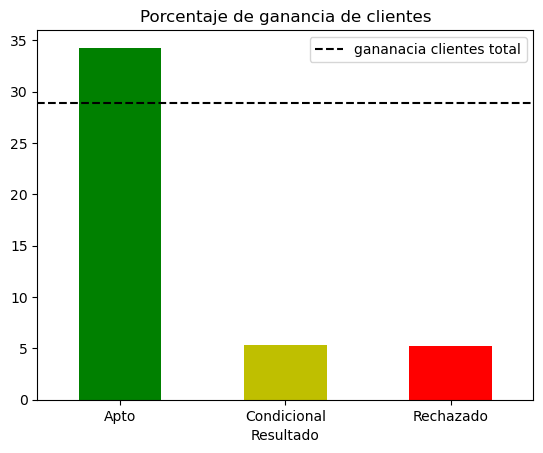

In [73]:


(retencion_clientes_pivot_taller_not_4_perc['gano']*100).plot.bar( title='Porcentaje de ganancia de clientes',rot=0,color=(['g','y','r']))

plt.xticks(rotation=0)

plt.axhline(y=retencion, color='k', linestyle='--')


labels = ["gananacia clientes total"]
plt.legend(labels=labels)

plt.show()

EL dataset solo incluye vehiculos que hayan realizado la tecnica en nuestro taller en algun momento


Para evaluar la gananacia de clientes deberiamos contar con la base de datos de los vehiculos de los demas talleres.


o por lo menos de nuestro taller competidor ' 123' 

# Dia con mas revisiones

In [408]:
lista_planillas_completa['day_of_week']=lista_planillas_completa['Fecha'].dt.dayofweek+1

lista_planillas_completa['day_name']=lista_planillas_completa['Fecha'].dt.day_name(locale='es_ES')



In [410]:
revisiones_por_dia=lista_planillas_completa.groupby('day_of_week')[['Dominio']].count()


In [421]:
horas_dia={1:9.5,2:9.5,3:9.5,4:9.5,5:9.5,6:4}

revisiones_por_dia['horas_por_dia']=revisiones_por_dia.index.map(horas_dia)

revisiones_por_dia['revisiones_por_hora']=(revisiones_por_dia['Dominio']/revisiones_por_dia['horas_por_dia']).round()


In [422]:
revisiones_por_dia

,Dominio,horas_por_dia,revisiones_por_hora
day_of_week,,,
1,30374,9.5,3197.0
2,31480,9.5,3314.0
3,32957,9.5,3469.0
4,33138,9.5,3488.0
5,33366,9.5,3512.0
6,15542,4.0,3886.0


# Revisiones por dia agrupado por MES 

In [425]:
lista_planillas_completa.groupby('Mes')[['Dominio']].count()


,Dominio
Mes,
1,17654
2,14736
3,13865
4,11456
5,11503
6,12546
7,14836
8,14706
9,15182


# Hora de mas Revisiones 

In [426]:
test=lista_planillas_completa[['Inicio','Fin','Dominio','Fecha']].copy()
#Cambiar hora_resultado a formato datetime
test['Fin1']=pd.to_datetime(test['Fin'],format="%H:%M")

test['hora']=test['Fin1'].dt.hour
test.groupby('hora')[['Dominio']].count()


,Dominio
hora,
2,5
7,6076
8,20228
9,21076
10,21317
11,21072
12,2237
13,1689
14,10200


# Revision mas tarde y mas temprana 

In [427]:
test.sort_values('Fin',ascending=True).head(10)

,Inicio,Fin,Dominio,Fecha,Fin1,hora
35259,18:31,02:00,MIK300,2016-07-07,1900-01-01 02:00:00,2
148848,18:32,02:00,AC099XW,2021-10-28,1900-01-01 02:00:00,2
94312,17:21,02:00,MQH410,2019-03-22,1900-01-01 02:00:00,2
167290,09:47,02:00,GGG944,2022-08-08,1900-01-01 02:00:00,2
89936,08:07,02:00,KWI676,2019-01-12,1900-01-01 02:00:00,2
73101,07:25,07:25,GGZ739,2018-03-22,1900-01-01 07:25:00,7
44245,07:26,07:26,NQV400,2016-12-06,1900-01-01 07:26:00,7
59013,07:26,07:26,NAL779,2017-08-10,1900-01-01 07:26:00,7
64006,07:26,07:26,UBO554,2017-11-03,1900-01-01 07:26:00,7
59424,07:26,07:26,IUZ276,2017-08-17,1900-01-01 07:26:00,7


In [429]:
test.sort_values('Fin',ascending=False).head()

,Inicio,Fin,Dominio,Fecha,Fin1,hora
5036,20:29,20:43,DFD312,2015-01-13,1900-01-01 20:43:00,20
5035,20:29,20:39,ICT474,2015-01-13,1900-01-01 20:39:00,20
5034,20:24,20:35,KHA746,2015-01-13,1900-01-01 20:35:00,20
89623,20:18,20:32,EEA711,2019-01-07,1900-01-01 20:32:00,20
5033,20:21,20:31,BKJ484,2015-01-13,1900-01-01 20:31:00,20


In [430]:
lista_planillas_completa[lista_planillas_completa['Dominio']=='KWI676']

,Fecha,Inicio,hora_Resultado,Fin,Tipo,Uso,Categoría,Certificado,Vence,Dominio,...,Planilla&Dominio,Anio,Mes,Mes_label,Anio y Mes,Razón Social Unica,Modelo,antiguedad_revision,day_of_week,day_name
89309,2019-01-03,08:23,08:35,08:36,P,X,UP,NaN,03/03/2019,KWI676,...,1089310KWI676,2019,1,Enero,20191,SINKOVICH ROCIO CAROLINA,2012,7,4,Jueves
89934,2019-01-12,08:06,08:07,08:06,P,X,UP,NaN,12/01/2019,KWI676,...,1089935KWI676,2019,1,Enero,20191,SINKOVICH ROCIO CAROLINA,2012,7,6,Sábado
89936,2019-01-12,08:07,08:16,02:00,P,X,UP,D 722255,12/01/2021,KWI676,...,1089937KWI676,2019,1,Enero,20191,SINKOVICH ROCIO CAROLINA,2012,7,6,Sábado
129166,2021-01-19,08:23,08:35,08:35,P,X,UP,E 445954,19/01/2022,KWI676,...,1129167KWI676,2021,1,Enero,20211,SINKOVICH ROCIO CAROLINA,2012,9,2,Martes
172353,2022-10-27,09:46,09:56,09:57,P,X,UP,E 964018,27/10/2023,KWI676,...,1172354KWI676,2022,10,Octubre,202210,GALARZA FELIX OSCAR,2012,10,4,Jueves


In [431]:
test[test['Dominio']=='AC099XW']

,Inicio,Fin,Dominio,Fecha,Fin1,hora
106971,17:10,17:31,AC099XW,2019-11-12,1900-01-01 17:31:00,17


# Anomalias mas comunes

In [432]:
# Importar planillas de detalles
planilla_anomalias=pd.read_csv('DATASET/0.0.Anomalias.COMPLETE.csv',
                              index_col='Planilla'
                              #dtype={'Modelo':'Int64','Planilla':'Int64'})
                              )


In [433]:

#Eliminar columna innecesaria
planilla_anomalias.drop(columns='Unnamed: 0',inplace=True)

In [434]:


#cambiar nombre columna

planilla_anomalias.rename(columns={'Código':'Codigo','Descripción':'Descripcion'},inplace=True)

#Hacer NAN a los  codigos que no son numeros:
planilla_anomalias['Codigo']=pd.to_numeric(planilla_anomalias['Codigo'],errors='coerce')


#Eliminar NAN : 
planilla_anomalias.dropna(subset='Codigo',inplace=True)

#Hacer la columna codigo int
planilla_anomalias['Codigo']=planilla_anomalias['Codigo'].astype('Int64')



In [435]:
planilla_anomalias['Descripcion']

Planilla
1173505    Tren Delantero, Tren Trasero, Suspensión > Amo...
1173505    Tren Delantero, Tren Trasero, Suspensión > Amo...
1173505    Carrocería > Exterior > Chapa Patente > Patent...
1124182    Carrocería > Exterior > Chapa Patente > Patent...
1053004    Carrocería > Exterior > Chapa Patente > Faltan...
                                 ...                        
1095335    Frenos > Pruebas del Sistema de Freno > Presta...
1095335    Frenos > Freno de Estacionamiento > Recorrido ...
1095335    Chasis > Bastidor del Chasis > Torceduras, Dob...
1095335    Carrocería > Exterior > Chapa Patente > Faltan...
1095335    Carrocería > Parabrisas. Inexistente, Visibili...
Name: Descripcion, Length: 292110, dtype: object

In [436]:
planilla_anomalias.groupby('Codigo').count().sort_values('Gravedad',ascending=False)[['Gravedad']]

,Gravedad
Codigo,
60101,24231
10401,9348
50103,8398
30409,8011
30404,7577
...,...
72201,1
120201,1
210101,1


agregar label a cada codigo de anomalia

# Resultados segun antiguedad del vehiculo

In [438]:
lista_planillas_completa

,Fecha,Inicio,hora_Resultado,Fin,Tipo,Uso,Categoría,Certificado,Vence,Dominio,...,Planilla&Dominio,Anio,Mes,Mes_label,Anio y Mes,Razón Social Unica,Modelo,antiguedad_revision,day_of_week,day_name
0,2014-10-14,17:51,18:10,18:10,P,X,UP,B 919698,14/10/2015,EOE606,...,1000001EOE606,2014,10,Octubre,201410,ROSSO LARA BELEN,2004,10,2,Martes
1,2014-10-14,17:55,18:29,18:29,G,P,M3,NaN,NaN,FUU099,...,1000002FUU099*,2014,10,Octubre,201410,EMPRESA SAN JOSE S A,<NA>,<NA>,2,Martes
2,2014-10-14,18:14,18:30,18:30,P,X,UP,B 919699,14/10/2015,SWH893,...,1000003SWH893,2014,10,Octubre,201410,BLASCO PEDRO IGNACIO,1987,27,2,Martes
3,2014-10-14,18:16,18:38,18:38,G,C,N1,L 878851,14/10/2015,FJZ512,...,1000004FJZ512*,2014,10,Octubre,201410,BRITES ANGEL HERNAN,<NA>,<NA>,2,Martes
4,2014-10-14,19:00,19:19,19:19,G,C,N2,NaN,14/11/2014,WMD264,...,1000005WMD264,2014,10,Octubre,201410,ALFONSO CLAUDIO ROLANDO,<NA>,<NA>,2,Martes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176852,2022-12-31,11:22,11:36,11:36,G,C,N3,S 881044,30/06/2023,BTL242,...,1176853BTL242,2022,12,Diciembre,202212,POURCEL FABRICIO UBALDO,1997,25,6,Sábado
176853,2022-12-31,11:24,11:34,11:34,P,X,UP,E 998166,31/12/2024,AB840PZ,...,1176854AB840PZ,2022,12,Diciembre,202212,GOMEZ CRISTIAN ADRIAN,2017,5,6,Sábado
176854,2022-12-31,11:30,11:44,11:44,P,X,UP,E 998167,31/12/2024,OOU150,...,1176855OOU150,2022,12,Diciembre,202212,PEREYRA ROMINA ALEJANDRA,2015,7,6,Sábado
176855,2022-12-31,11:35,11:35,11:35,P,X,NaN,NaN,31/12/2022,AA246UU,...,1176856AA246UU,2022,12,Diciembre,202212,NaN,<NA>,<NA>,6,Sábado


In [439]:
#eliminar anulados
test=lista_planillas_completa[lista_planillas_completa['Resultado']!='Anulado'].copy()

resultados_por_antiguedad=pd.crosstab(test['antiguedad_revision'],
                                      test['Resultado'],
                                      test['Dominio'],
                                      aggfunc='count',
                                     normalize='index')
porc_aptos=resultados_por_antiguedad.loc[:,['Apto']].round(3)*100

In [440]:
porc_aptos_tot=test.groupby('Resultado').count()

tot_rev=porc_aptos_tot['Dominio'].sum()

aptos_tot=porc_aptos_tot.loc['Apto','Dominio']

aptos_p=(aptos_tot/tot_rev).round(3)*100

aptos_p

87.4

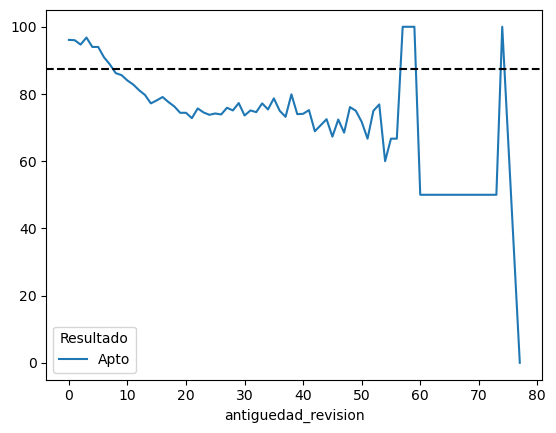

In [441]:
porc_aptos.plot.line()

plt.axhline(y=aptos_p, color='k', linestyle='--')

plt.show()

# Revisiones vs patentamientos

In [482]:
parque_automotor=pd.read_csv('DATASET/Parque_automotor.csv',index_col=0)
parque_automotor

,Anio,Mes,Anio y Mes,BUENOS AIRES,CABA,CATAMARCA,CORDOBA,CORRIENTES,CHACO,CHUBUT,...,RIO NEGRO,SALTA,SAN JUAN,SAN LUIS,SANTA CRUZ,SANTA FE,S. DEL ESTERO,TUCUMAN,T. DEL FUEGO,Fecha_dt
0,2010,1,20101,3557460,1094202,51305,974107,141698,127352,183055,...,163866,146441,137701,94083,101238,874331,77402,184245,51220,2010-01-01
1,2010,2,20102,3582347,1106044,51877,982376,143440,128980,184842,...,165032,148091,138589,94739,102571,881252,78242,186177,51799,2010-01-02
2,2010,3,20103,3597010,1113739,52150,986840,144372,129745,185812,...,165741,149012,139062,95120,103229,884886,78681,187115,52214,2010-01-03
3,2010,4,20104,3616018,1123774,52493,992314,145630,130620,187016,...,166572,150182,139716,95596,104072,889335,79287,188337,52736,2010-01-04
4,2010,5,20105,3632907,1132885,52809,997403,146789,131267,187965,...,167360,151183,140229,96018,104807,893345,79760,189517,53239,2010-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2022,8,20228,6504518,1586105,124927,1728997,330096,283480,340708,...,355381,334576,265129,214619,198923,1484037,196886,432927,103233,2022-01-08
152,2022,9,20229,6515416,1587752,125073,1732028,330898,284121,341074,...,356106,335352,265598,215095,199011,1486057,197448,433631,103297,2022-01-09
153,2022,10,202210,6525113,1589720,125178,1734852,331622,284712,341405,...,356785,336098,266090,215606,199168,1488202,197948,434307,103387,2022-01-10
154,2022,11,202211,6535378,1591878,125263,1737769,332293,285333,341737,...,357579,336878,266553,216077,199337,1490183,198371,435017,103561,2022-01-11


In [497]:
parque_automotor_chaco=parque_automotor[['Anio y Mes','CHACO']].copy()

In [500]:
#parque_autmotor_chaco=pd.DataFrame()
parque_automotor_chaco

,Anio y Mes,CHACO
0,20101,127352
1,20102,128980
2,20103,129745
3,20104,130620
4,20105,131267
...,...,...
151,20228,283480
152,20229,284121
153,202210,284712
154,202211,285333


In [501]:
parque_automotor_chaco.set_index('Anio y Mes',inplace=True)

In [502]:
#Revisiones mes a mes 
lista_planillas_completa['Anio y Mes']=lista_planillas_completa['Anio y Mes'].astype('Int64')

revisiones_mes_a_mes=lista_planillas_completa.groupby('Anio y Mes')[['Dominio']].count()

revisiones_mes_a_mes.sort_values('Anio y Mes',ascending=True)

,Dominio
Anio y Mes,
20151,2111
20152,1565
20153,1535
20154,1596
20155,1496
...,...
202111,2047
202112,2407
202210,1866


In [503]:
test=parque_automotor_chaco.join(revisiones_mes_a_mes,how='left')
test.dropna(subset='Dominio',inplace=True)
test

,CHACO,Dominio
Anio y Mes,,
201410,191135,865.0
201411,191888,1571.0
201412,192373,1757.0
20151,193789,2111.0
20152,194733,1565.0
...,...,...
20228,283480,1948.0
20229,284121,2030.0
202210,284712,1866.0


<AxesSubplot:xlabel='Anio y Mes'>

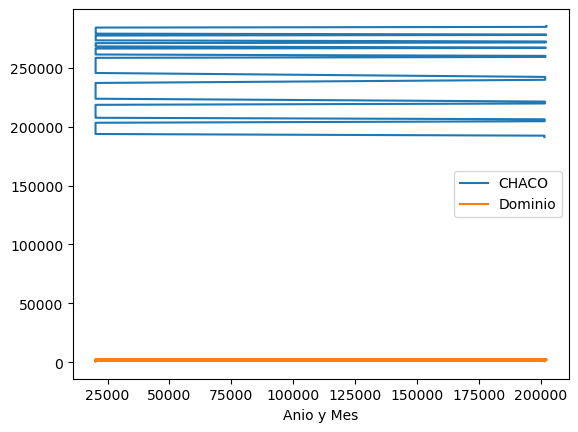

In [504]:
test.plot(kind='line')

# Revisiones linea 1 resultados pasajeros vs linea 2 